In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install jiwer

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import time
import codecs
from sklearn.model_selection import train_test_split
# Load and preprocess data
examples = []
file_name = "mn_en.txt"  # Adjust path as needed
with codecs.open(file_name, 'r', encoding='utf-8', errors='ignore') as f:
    while True:
        line = f.readline()
        if not line:
            break
        arr = line.strip().split("+++++SEP+++++")
        if len(arr) == 2:
            mn_text = arr[0].strip()  # Mongolian text
            en_text = arr[1].strip()  # English text
            examples.append((mn_text, en_text))


In [ ]:
from transformers import AutoTokenizer

train_examples, val_examples = train_test_split(examples, test_size=0.2, random_state=42)

tokenizer_en = AutoTokenizer.from_pretrained('bert-base-uncased')
tokenizer_mn = AutoTokenizer.from_pretrained('tugstugi/bert-base-mongolian-cased', use_fast=False)

MAX_LENGTH = 40

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/46.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.00M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/16.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

In [ ]:
class TranslationDataset(Dataset):
    def __init__(self, examples, tokenizer_mn, tokenizer_en, max_length=40):
        self.examples = examples
        self.tokenizer_mn = tokenizer_mn
        self.tokenizer_en = tokenizer_en
        self.max_length = max_length
        self.data = self._prepare_data()

    def _prepare_data(self):
        data = []
        for mn_text, en_text in self.examples:
            # Encode with special tokens (using vocab_size as SOS and vocab_size+1 as EOS)
            mn_tokens = [self.tokenizer_mn.vocab_size] + self.tokenizer_mn.encode(mn_text) + [self.tokenizer_mn.vocab_size + 1]
            en_tokens = [self.tokenizer_en.vocab_size] + self.tokenizer_en.encode(en_text) + [self.tokenizer_en.vocab_size + 1]

            # Skip examples exceeding max_length
            if len(mn_tokens) <= self.max_length and len(en_tokens) <= self.max_length:
                # Pad sequences
                mn_padded = mn_tokens + [0] * (self.max_length - len(mn_tokens))
                en_padded = en_tokens + [0] * (self.max_length - len(en_tokens))
                data.append({
                    'mn': torch.tensor(mn_padded, dtype=torch.long),
                    'en': torch.tensor(en_padded, dtype=torch.long)
                })
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Create datasets and dataloaders
train_dataset = TranslationDataset(train_examples, tokenizer_mn, tokenizer_en, MAX_LENGTH)
val_dataset = TranslationDataset(val_examples, tokenizer_mn, tokenizer_en, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
class Translator(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=256, nhead=8, num_layers=3, dim_feedforward=512, dropout=0.1):
        super(Translator, self).__init__()
        self.src_embedding = nn.Embedding(src_vocab_size + 2, d_model)  # +2 for SOS/EOS
        self.tgt_embedding = nn.Embedding(tgt_vocab_size + 2, d_model)  # +2 for SOS/EOS
        self.positional_encoding = self.create_positional_encoding(MAX_LENGTH, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.fc_out = nn.Linear(d_model, tgt_vocab_size + 2)
        self.d_model = d_model

    def create_positional_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  # Shape: (1, max_len, d_model)

    def forward(self, src, tgt):
        batch_size = src.size(0)
        src = self.src_embedding(src) + self.positional_encoding[:, :src.size(1), :].to(src.device)
        tgt = self.tgt_embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :].to(tgt.device)
        src_mask = self.transformer.generate_square_subsequent_mask(src.size(1)).to(src.device)
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1)).to(tgt.device)
        output = self.transformer(src.transpose(0, 1), tgt.transpose(0, 1), src_mask, tgt_mask)
        return self.fc_out(output.transpose(0, 1))

In [ ]:
def train_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in train_loader:
        src = batch['mn'].to(device)
        tgt = batch['en'].to(device)
        tgt_input = tgt[:, :-1]  # Exclude last token for input
        tgt_output = tgt[:, 1:]  # Exclude first token for output

        optimizer.zero_grad()
        output = model(src, tgt_input)
        loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

In [ ]:
def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            src = batch['mn'].to(device)
            tgt = batch['en'].to(device)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            output = model(src, tgt_input)
            loss = criterion(output.reshape(-1, output.size(-1)), tgt_output.reshape(-1))
            total_loss += loss.item()
    return total_loss / len(val_loader)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Translator(
    src_vocab_size=tokenizer_mn.vocab_size,
    tgt_vocab_size=tokenizer_en.vocab_size,
    d_model=256,
    nhead=8,
    num_layers=3,
    dim_feedforward=512
).to(device)

Epoch 1/10, Train Loss: 3.9073, Val Loss: 3.1507, Time: 1032.23s
Epoch 2/10, Train Loss: 2.9787, Val Loss: 2.6319, Time: 1029.67s
Epoch 3/10, Train Loss: 2.5834, Val Loss: 2.3151, Time: 1027.25s
Epoch 4/10, Train Loss: 2.3320, Val Loss: 2.1167, Time: 1028.38s
Epoch 5/10, Train Loss: 2.1579, Val Loss: 1.9749, Time: 1029.40s
Epoch 6/10, Train Loss: 2.0295, Val Loss: 1.8715, Time: 1028.04s
Epoch 7/10, Train Loss: 1.9302, Val Loss: 1.7942, Time: 1027.78s
Epoch 8/10, Train Loss: 1.8513, Val Loss: 1.7375, Time: 1036.19s
Epoch 9/10, Train Loss: 1.7864, Val Loss: 1.6889, Time: 1031.42s
Epoch 10/10, Train Loss: 1.7319, Val Loss: 1.6468, Time: 1029.95s


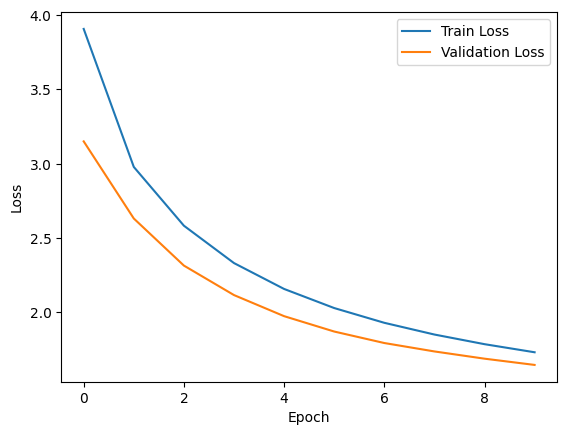

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

num_epochs = 10
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    val_loss = evaluate(model, val_loader, criterion, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Time: {time.time()-start_time:.2f}s")

# Plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
import re
from jiwer import wer

def preprocess_text(text):
    contractions = {
        "you're": "you are",
        "i'm": "i am",
        "don't": "do not",
        "can't": "cannot",
        "'re": "are",
        "'ve": "have",
        "'ll": "will",
        "'d": "would",
        "'m": "am",
        "'s": "is",
        "won't": "will not",
        "it's": "its",
        "i'm": "i am",  # Ensure contraction "i'm" is captured correctly
        "i ' m": "i am",  # Handle cases where tokenization adds spaces
        "re"  : "are",
    }

    for contraction, full_form in contractions.items():
        text = re.sub(r"\b" + re.escape(contraction) + r"\b", full_form, text)

    text = re.sub(r'\b(you)\s+(re)\b', r'you are', text)

    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()

    return text

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Translator(
    src_vocab_size=tokenizer_mn.vocab_size,
    tgt_vocab_size=tokenizer_en.vocab_size,
    d_model=256,
    nhead=8,
    num_layers=3,
    dim_feedforward=512
).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/bert/translator_model.pth', map_location=torch.device('cpu')))

In [ ]:
class Translator(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=256, nhead=8, num_layers=3, dim_feedforward=512, dropout=0.1):
        super(Translator, self).__init__()
        self.src_embedding = nn.Embedding(src_vocab_size + 2, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size + 2, d_model)
        self.positional_encoding = self.create_positional_encoding(MAX_LENGTH, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        self.fc_out = nn.Linear(d_model, tgt_vocab_size + 2)
        self.d_model = d_model

    def create_positional_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.unsqueeze(0)  # Shape: (1, max_len, d_model)

    def forward(self, src, tgt):
        batch_size = src.size(0)
        src = self.src_embedding(src) + self.positional_encoding[:, :src.size(1), :].to(src.device)
        tgt = self.tgt_embedding(tgt) + self.positional_encoding[:, :tgt.size(1), :].to(tgt.device)
        src_mask = self.transformer.generate_square_subsequent_mask(src.size(1)).to(src.device)
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1)).to(tgt.device)
        output = self.transformer(src.transpose(0, 1), tgt.transpose(0, 1), src_mask, tgt_mask)
        return self.fc_out(output.transpose(0, 1))

In [ ]:
from jiwer import wer
def translate_sentence(model, sentence, tokenizer_mn, tokenizer_en, max_length=40, device='cuda'):
    model.eval()
    mn_tokens = [tokenizer_mn.vocab_size] + tokenizer_mn.encode(sentence) + [tokenizer_mn.vocab_size + 1]
    if len(mn_tokens) > max_length:
        mn_tokens = mn_tokens[:max_length]
    src = torch.tensor([mn_tokens + [0] * (max_length - len(mn_tokens))], dtype=torch.long).to(device)
    tgt = torch.tensor([[tokenizer_en.vocab_size]], dtype=torch.long).to(device)  # SOS token

    with torch.no_grad():
        for _ in range(max_length - 1):  # -1 to account for SOS
            output = model(src, tgt)
            next_token = output[:, -1, :].argmax(dim=-1).unsqueeze(0)  # Greedy decoding
            tgt = torch.cat([tgt, next_token], dim=1)
            if next_token.item() == tokenizer_en.vocab_size + 1:
                break

    tgt_tokens = tgt.squeeze().cpu().numpy()
    translated_tokens = [token for token in tgt_tokens if token not in [tokenizer_en.vocab_size, tokenizer_en.vocab_size + 1, 0]]
    translated_text = tokenizer_en.decode(translated_tokens, skip_special_tokens=True)
    return translated_text

In [ ]:
def translate_sentence(model, sentence, tokenizer_mn, tokenizer_en, max_length=40, device='cuda'):
    model.eval()

    mn_tokens = [tokenizer_mn.vocab_size] + tokenizer_mn.encode(sentence) + [tokenizer_mn.vocab_size + 1]
    if len(mn_tokens) > max_length:
        mn_tokens = mn_tokens[:max_length]
    src = torch.tensor([mn_tokens + [0] * (max_length - len(mn_tokens))], dtype=torch.long).to(device)

    tgt = torch.tensor([[tokenizer_en.vocab_size]], dtype=torch.long).to(device)  # SOS token

    with torch.no_grad():
        for _ in range(max_length - 1):  # -1 to account for SOS
            output = model(src, tgt)
            next_token = output[:, -1, :].argmax(dim=-1).unsqueeze(0)  # Greedy decoding
            tgt = torch.cat([tgt, next_token], dim=1)

            # Stop if EOS token is generated
            if next_token.item() == tokenizer_en.vocab_size + 1:
                break

    tgt_tokens = tgt.squeeze().cpu().numpy()
    translated_tokens = [token for token in tgt_tokens if token not in [tokenizer_en.vocab_size, tokenizer_en.vocab_size + 1, 0]]
    translated_text = tokenizer_en.decode(translated_tokens, skip_special_tokens=True)

    return translated_text

mongolian_sentence = "Би ном унших дуртай."
translated_sentence = translate_sentence(model, mongolian_sentence, tokenizer_mn, tokenizer_en, MAX_LENGTH, device)
print(f"Mongolian: {mongolian_sentence}")
print(f"English: {translated_sentence}")

Mongolian: Би ном унших дуртай.
English: i like reading books.


In [ ]:
from jiwer import wer

test_pairs = [
    ("Би өглөө эрт босдог.", "i wake up early in the morning."),
    ("Би ном унших дуртай.", "i like reading books."),
    ("Өнөөдөр сайхан өдөр байна.", "today is a beautiful day."),
    ("Би зүгээр ээ, баярлалаа.", "I'm fine, thank you."),
    ("Би аз жаргалтай байна.", "i am happy."),
    ("Чи хаашаа явж байна вэ?", "where are you going?")
]

for mn_sentence, en_reference in test_pairs:
    translated = translate_sentence(model, mn_sentence, tokenizer_mn, tokenizer_en, MAX_LENGTH, device)
    score = wer(en_reference, translated)

    print(f"\nMongolian: {mn_sentence}")
    print(f"Reference: {en_reference}")
    print(f"Translation: {translated}")
    print(f"WER: {score:.4f}")


Mongolian: Би өглөө эрт босдог.
Reference: i wake up early in the morning.
Translation: i ' m early in the morning.
WER: 0.2857

Mongolian: Би ном унших дуртай.
Reference: i like reading books.
Translation: i like reading books.
WER: 0.0000

Mongolian: Өнөөдөр сайхан өдөр байна.
Reference: today is a beautiful day.
Translation: today is a good day.
WER: 0.2000

Mongolian: Би зүгээр ээ, баярлалаа.
Reference: I'm fine, thank you.
Translation: okay, thank you.
WER: 0.5000

Mongolian: Би аз жаргалтай байна.
Reference: i am happy.
Translation: i am happy.
WER: 0.0000

Mongolian: Чи хаашаа явж байна вэ?
Reference: where are you going?
Translation: where is you going?
WER: 0.2500


In [ ]:
from transformers import MarianMTModel, MarianTokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
marian_model_de = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-de").to(device)
marian_tokenizer_de = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")
marian_model_es = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-es").to(device)
marian_tokenizer_es = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")

In [ ]:
from transformers import MarianMTModel, MarianTokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
marian_model_de = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-de").to(device)
marian_tokenizer_de = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-de")
marian_model_es = MarianMTModel.from_pretrained("Helsinki-NLP/opus-mt-en-es").to(device)
marian_tokenizer_es = MarianTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-es")

def translate_marian(model, tokenizer, text, max_length=40, device='cuda'):
    model.eval()
    if not text.strip():
        return "Translation failed"
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=max_length).to(device)
    translated = model.generate(**inputs)
    translated_text = tokenizer.batch_decode(translated, skip_special_tokens=True)[0]
    return translated_text

test_pairs = [
    (
        "Өнөөдөр сайхан өдөр байна.",
        "today is a beautiful day.",
        "Heute ist ein schöner Tag.",
        "Hoy es un día hermoso."
    ),
    (
        "Би зүгээр ээ, баярлалаа.",
        "I'm fine, thank you.",
        "Mir geht's gut, danke.",
        "Estoy bien, gracias."
    ),
    (
        "Би аз жаргалтай байна.",
        "i am happy.",
        "Ich bin glücklich.",
        "Estoy feliz."
    )
]

print("Evaluating translations with WER (English, German, Spanish):")
for mn_sentence, en_reference, de_reference, es_reference in test_pairs:
    en_translated = translate_sentence(model, mn_sentence, tokenizer_mn, tokenizer_en, MAX_LENGTH, device)

    de_translated = translate_marian(marian_model_de, marian_tokenizer_de, en_translated, MAX_LENGTH, device)
    es_translated = translate_marian(marian_model_es, marian_tokenizer_es, en_translated, MAX_LENGTH, device)

    en_wer = wer(en_reference, en_translated)
    de_wer = wer(de_reference, de_translated)
    es_wer = wer(es_reference, es_translated)

    print(f"Reference (DE): {de_reference}")
    print(f"Translated (DE): {de_translated}")
    print(f"WER (DE): {de_wer:.4f}")
    print(f"Reference (ES): {es_reference}")
    print(f"Translated (ES): {es_translated}")
    print(f"WER (ES): {es_wer:.4f}")

Evaluating translations with WER (English, German, Spanish):
Reference (DE): Heute ist ein schöner Tag.
Translated (DE): Heute ist ein guter Tag.
WER (DE): 0.2000
Reference (ES): Hoy es un día hermoso.
Translated (ES): Hoy es un buen día.
WER (ES): 0.4000
Reference (DE): Mir geht's gut, danke.
Translated (DE): Okay, danke.
WER (DE): 0.7500
Reference (ES): Estoy bien, gracias.
Translated (ES): Está bien, gracias.
WER (ES): 0.3333
Reference (DE): Ich bin glücklich.
Translated (DE): Ich bin glücklich.
WER (DE): 0.0000
Reference (ES): Estoy feliz.
Translated (ES): Soy feliz.
WER (ES): 0.5000
